# Generalized Cash Balance problem - One Step Ahead Optimization

In [1]:
import gurobipy as gb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## OSA SIMULATION N = M = 1
We present a simulation of the one-step-ahead optimal control applied to the generalized cash balance problem as illustrated in the paper titled "The generalized cash balance problem: optimization-based one step ahead" by Amit Bhaya and Eugenius Kaszkurewicz. $\\$
It is considered a different distribution for the demands, or cash flows, incurred by the cash account - Bernoulli, uniform and normal distribution. $\\$
There are two performance indexes taken into consideration as the objective function of the optimization problem. The general objective function is formulated as follows: $ J_{os}(k+1) = \sum_j k_jy_j(k+1) - \sum_i \mu_ix_i(k+1)$ $\\$
For the first performance index we consider $k_j = 0$ and $\mu_i = 1$, thus we are minimizing the sum of cash accounts. In the second case, we consider $k_j = 1$ and $\mu_i = 1$, thus we are maximizing the sum of investment accounts while minimizing the sum of cash accounts. $\\$
The following simulation is applied to a single cash account and a single investment account. Cash or current account is used for day-to-day operations, while the investment account is used to store excess in current account balance to earn higher returns. $\\$
In the implementation we apply the optimizaton model on a single day and then iterate the optimization over a time-window of 30 days. $\\$
The optimization problem we implement is a mixed integer-linear problem. $\\$
Parameters are chosen as follows:
- $x(0) = y(0) = 40$ as the initial balance;
- $ \alpha = 0.01$ as the interest rate on cash account;
- $ \beta = 0.04$ as the interest rate on investment account;
- $ \gamma = 0.02$ as the transaction cost;
- $ K_f = 30 $ as the discrete time-window;
- $ x_{min} = 1$ or $x_{min} = 5$ for bernoulli/uniform or normal demand, respectively;
- $ x_{max} = 2$ or $x_{max} = 25$ for bernoulli/uniform or normal demand, respectively;
- $ y_{min} = 0$

In [2]:
# Class for optimization model used in case we have a single investment account and a single cash account

class Model_1:
    
    a = 0.01 # Interest over cash account
    b = 0.04 # Interest over investment account
    c = 0.02 # Transfer fee

    u = 0 # Initializing variable to store values of control variable

    def __init__(self, M, x_data, y_data, demand):
        self.M = M
        self.x_data = x_data # Previous cash account balance input
        self.y_data = y_data # Previous investment account balance input
        self.demand = demand

    def optim(self,dtype,index):
        osa = gb.Model()
        osa.modelSense = gb.GRB.MAXIMIZE
        osa.setParam('OutputFlag',0)

        # Initializing control variables

        up = osa.addVar(name = "up")
        un = osa.addVar(name = "un")
        d_1 = osa.addVar(vtype = gb.GRB.BINARY)
        d_2 = osa.addVar(vtype = gb.GRB.BINARY)
        x = osa.addVar(name = "x")
        y = osa.addVar(name = "y")

        # Constraints

        osa.addConstr((1+self.a)*self.x_data + (up-un)-self.c*(up+un)-self.demand==x)
        osa.addConstr((1+self.b)*self.y_data - (up-un) == y)
        osa.addConstr(up <= self.M*d_1)
        osa.addConstr(un <= self.M*d_2)
        osa.addConstr(d_1 + d_2 == 1)
        if dtype == "normal":
            osa.addConstr(5 <= x)
            osa.addConstr(x <= 25)
        else:
            osa.addConstr( 1 <= x)
            osa.addConstr(x <= 2)
        osa.addConstr(0 <= y)
        #if index == "maxmin":
            #osa.addConstr(y <= 500)

        # Objective function based on performance index chosen

        if index == "maxmin":
            osa.setObjective(y-x) # First performance index
        elif index == "min":
            osa.setObjective(-x) # Second performance index
        osa.optimize()

        obj = osa.getObjective()
        '''
        if up.x == 0.0:
            self.u = un.x
        else:
            self.u = up.x
        '''

        self.u = up.x - un.x

        return self.u,x.x,y.x,obj.getValue()
    



In [3]:
# GENERATE BINOMIAL DISTRIBUTION
binomial_demand = np.random.binomial(1,0.5,30)

# AVERAGE DEMAND
average_binomial_demand = sum(binomial_demand)/len(binomial_demand)

# GENERATE UNIFORM DISTRIBUTION
uniform_demand = np.random.uniform(-1,1,30)

# AVERAGE DEMAND
average_uniform_demand = sum(uniform_demand)/len(uniform_demand)

# GENERATE NORMAL DISTRIBUTION
normal_demand = np.random.normal(1,1,30)

# AVERAGE DEMAND
average_normal_demand = sum(normal_demand)/len(normal_demand)

In [4]:
# FUNCTION DEFINITION: Average wealth gain 

def wealth_gain(w_f,w_1):
    w = (w_f-w_1)/w_1
    return w


### Bernoulli demand distribution - min index

In [5]:
# Data structures to store control variables values

u_data_bernoulli = [0 for i in range(30)]
obj_bernoulli = [0 for i in range(30)]

x_data_bernoulli = [40 for i in range(31)]
y_data_bernoulli = [40 for i in range(31)]

# Data structure for storing wealth function values

wealth_perday = [0 for i in range(30)]

# Application of the optimizing model on a 30-days time-window

for i in range(1,31):
    model_bernoulli = Model_1(500,x_data_bernoulli[i-1],y_data_bernoulli[i-1],binomial_demand[i-1])

    u_data_bernoulli[i-1],x_data_bernoulli[i],y_data_bernoulli[i],obj_bernoulli[i-1] = model_bernoulli.optim("binomial","min")

    # Wealth gain per day
    wealth_perday[i-1] = ((x_data_bernoulli[i]+y_data_bernoulli[i])-(x_data_bernoulli[i-1]+y_data_bernoulli[i-1]))


# Wealth gain over entire time_window
w_f = x_data_bernoulli[-1]+y_data_bernoulli[-1]
w_i = x_data_bernoulli[0]+y_data_bernoulli[0]
wealth_bernoulli = wealth_gain(w_f,w_i)

average_bernoulli = sum(wealth_perday)/len(wealth_perday)

# Average balance over time-window
average_bal_bernoulli = sum(x_data_bernoulli)/len(x_data_bernoulli)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02


### Uniform demand distribution - min index

In [6]:
u_data_uniform = [0 for i in range(30)]
obj_uniform = [0 for i in range(30)]

x_data_uniform = [40 for i in range(31)]
y_data_uniform = [40 for i in range(31)]

wealth_perday = [0 for i in range(30)]

for i in range(1,31):
    model_uniform = Model_1(50,x_data_uniform[i-1],y_data_uniform[i-1],uniform_demand[i-1])

    u_data_uniform[i-1],x_data_uniform[i],y_data_uniform[i],obj_uniform[i-1] = model_uniform.optim("uniform","min")

    wealth_perday[i-1] = ((x_data_uniform[i]+y_data_uniform[i])-(x_data_uniform[i-1]+y_data_uniform[i-1]))
    
w_f = x_data_uniform[-1]+y_data_uniform[-1]
w_i = x_data_uniform[0]+y_data_uniform[0]
wealth_uniform = wealth_gain(w_f,w_i)
average_uniform = sum(wealth_perday)/len(wealth_perday)

average_bal_uniform = sum(x_data_uniform)/len(x_data_uniform)


### Normal demand distribution - min index

In [7]:
u_data_normal = [0 for i in range(30)]
obj_normal = [0 for i in range(30)]

x_data_normal = [40 for i in range(31)]
y_data_normal = [40 for i in range(31)]

wealth_perday = [0 for i in range(30)]

for i in range(1,31):
    model_normal = Model_1(50,x_data_normal[i-1],y_data_normal[i-1],normal_demand[i-1])

    u_data_normal[i-1],x_data_normal[i],y_data_normal[i],obj_normal[i-1] = model_normal.optim("normal","min")

    wealth_perday[i-1] = ((x_data_normal[i]+y_data_normal[i])-(x_data_normal[i-1]+y_data_normal[i-1]))
    
w_f = x_data_normal[-1]+y_data_normal[-1]
w_i = x_data_normal[0]+y_data_normal[0]
wealth_normal = wealth_gain(w_f,w_i)
average_normal = sum(wealth_perday)/len(wealth_perday)

average_bal_normal = sum(x_data_normal)/len(x_data_normal)

### Table of average results

In [8]:
# 'i.v.' stands for initial value
average_results = pd.DataFrame({'Wealth gain wrt i.v.': [wealth_bernoulli,wealth_uniform,wealth_normal],'Average wealth gain per day': [average_bernoulli,average_uniform,average_normal] ,'Average balance': [average_bal_bernoulli,average_bal_uniform,average_bal_normal]},index = ('Bernoulli','Uniform','Normal'))
average_results

,Wealth gain wrt i.v.,Average wealth gain per day,Average balance
Bernoulli,1.843694,4.916518,2.258065
Uniform,2.099343,5.598249,2.258065
Normal,1.196891,3.191708,6.129032


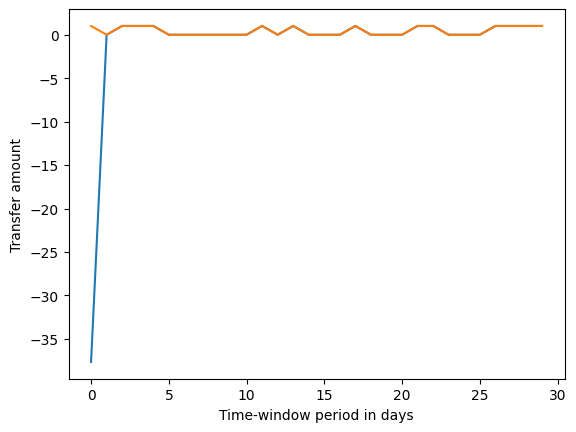

In [9]:
x_axis = np.arange(0,30)

plt.plot(x_axis,u_data_bernoulli)
plt.plot(x_axis,binomial_demand)

plt.xlabel('Time-window period in days')
plt.ylabel('Transfer amount')

plt.show()

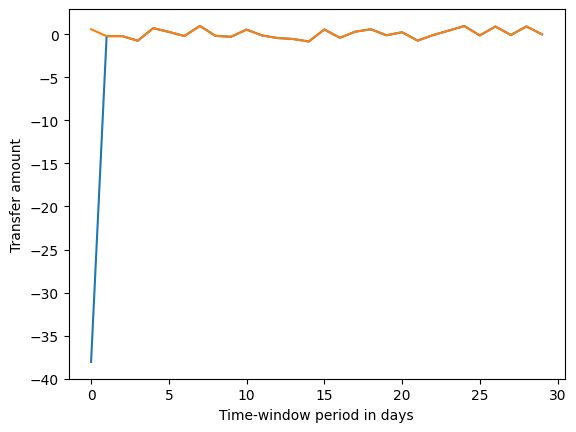

In [10]:
x_axis = np.arange(0,30)

plt.plot(x_axis,u_data_uniform)
plt.plot(x_axis,uniform_demand)

plt.xlabel('Time-window period in days')
plt.ylabel('Transfer amount')

plt.show()

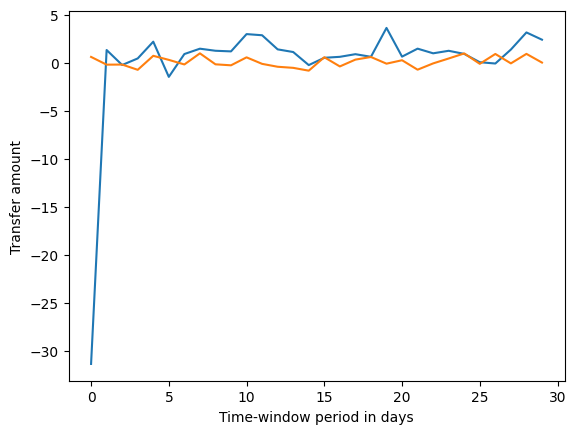

In [11]:
x_axis = np.arange(0,30)

plt.plot(x_axis,u_data_normal)
plt.plot(x_axis,uniform_demand)

plt.xlabel('Time-window period in days')
plt.ylabel('Transfer amount')

plt.show()

### Bernoulli demand distribution - maxmin index

In [12]:
# Data structures to store control variables values

u_data_bernoulli = [0 for i in range(30)]
obj_bernoulli = [0 for i in range(30)]

x_data_bernoulli = [40 for i in range(31)]
y_data_bernoulli = [40 for i in range(31)]

# Data structure for storing wealth function values

wealth_bernoulli = [0 for i in range(30)]

# Application of the optimizing model on a 30-days time-window

for i in range(1,31):
    model_bernoulli = Model_1(50,x_data_bernoulli[i-1],y_data_bernoulli[i-1],binomial_demand[i-1])

    u_data_bernoulli[i-1],x_data_bernoulli[i],y_data_bernoulli[i],obj_bernoulli[i-1] = model_bernoulli.optim("binomial","maxmin")

    # Wealth gain with respect to previous day wealth
    wealth_bernoulli[i-1] = ((x_data_bernoulli[i]+y_data_bernoulli[i])-(x_data_bernoulli[i-1]+y_data_bernoulli[i-1]))
    


# Average wealth gain over entire time_window
average_bernoulli = sum(wealth_bernoulli)/len(wealth_bernoulli)
average_bernoulli_1 = ((x_data_bernoulli[30]+y_data_bernoulli[30])-(x_data_bernoulli[0]+y_data_bernoulli[0]))/(x_data_bernoulli[0]+y_data_bernoulli[0])

# Average balance over time-window
average_bal_bernoulli = sum(x_data_bernoulli)/len(x_data_bernoulli)


### Uniform demand distribution - maxmin index

In [13]:
u_data_uniform = [0 for i in range(30)]
obj_uniform = [0 for i in range(30)]

x_data_uniform = [40 for i in range(31)]
y_data_uniform = [40 for i in range(31)]

wealth_uniform = [0 for i in range(30)]

for i in range(1,31):
    model_uniform = Model_1(50,x_data_uniform[i-1],y_data_uniform[i-1],uniform_demand[i-1])

    u_data_uniform[i-1],x_data_uniform[i],y_data_uniform[i],obj_uniform[i-1] = model_uniform.optim("uniform","maxmin")

    wealth_uniform[i-1] = ((x_data_uniform[i]+y_data_uniform[i])-(x_data_uniform[i-1]+y_data_uniform[i-1]))
    

average_uniform = sum(wealth_uniform)/len(wealth_uniform)
average_uniform_1 = ((x_data_uniform[30]+y_data_uniform[30])-(x_data_uniform[0]+y_data_uniform[0]))/(x_data_uniform[0]+y_data_uniform[0])

average_bal_uniform = sum(x_data_uniform)/len(x_data_uniform)


### Normal demand distribution - maxmin index

In [14]:
u_data_normal = [0 for i in range(30)]
obj_normal = [0 for i in range(30)]

x_data_normal = [40 for i in range(31)]
y_data_normal = [40 for i in range(31)]

wealth_normal = [0 for i in range(30)]

for i in range(1,31):
    model_normal = Model_1(50,x_data_normal[i-1],y_data_normal[i-1],normal_demand[i-1])

    u_data_normal[i-1],x_data_normal[i],y_data_normal[i],obj_normal[i-1] = model_normal.optim("normal","maxmin")

    wealth_normal[i-1] = ((x_data_normal[i]+y_data_normal[i])-(x_data_normal[i-1]+y_data_normal[i-1]))
    

average_normal = sum(wealth_normal)/len(wealth_normal)
average_normal_1 = ((x_data_normal[30]+y_data_normal[30])-(x_data_normal[0]+y_data_normal[0]))/(x_data_normal[0]+y_data_normal[0])

average_bal_normal = sum(x_data_normal)/len(x_data_normal)

In [15]:
average_results = pd.DataFrame({'Avg wealth gain wrt i.v.': [average_bernoulli_1,average_uniform_1,average_normal_1],'Average wealth gain per day': [average_bernoulli,average_uniform,average_normal] ,'Average balance': [average_bal_bernoulli,average_bal_uniform,average_bal_normal]},index = ('Bernoulli','Uniform','Normal'))
average_results

,Avg wealth gain wrt i.v.,Average wealth gain per day,Average balance
Bernoulli,1.843694,4.916518,2.258065
Uniform,2.099343,5.598249,2.258065
Normal,1.196891,3.191708,6.129032


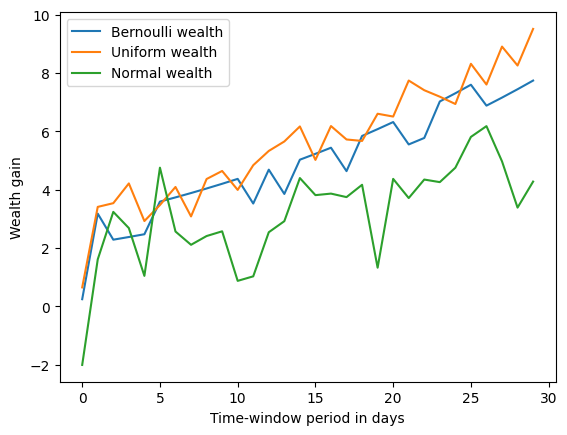

In [16]:
x_axis = np.arange(0,30)

plt.plot(x_axis,wealth_bernoulli)
plt.plot(x_axis,wealth_uniform)
plt.plot(x_axis,wealth_normal)

plt.legend(['Bernoulli wealth','Uniform wealth','Normal wealth'])

plt.xlabel('Time-window period in days')
plt.ylabel('Wealth gain')

plt.show()

### Note: 
Feasibility of the optimization problem is strictly related to the constraint on the maximum of y and initial conditions.